In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine,Inspector
import json
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import reliability.Fitters as F
import reliability.Distributions as D
from datetime import datetime as dt
from sqlalchemy import text
today = dt.today().strftime('%Y-%m-%d')

In [2]:
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
today = dt.today().strftime('%Y-%m-%d')

In [3]:
# 定义数据库连接信息
db_username = 'develop'
db_password = 'Dev&168!'
db_port = '3306'
# db_hostname = '172.24.139.117'
# db_name = 'zlaq_gd_ana'

In [4]:
db_name = 'zlaq_prod'
db_hostname = '172.24.139.206'

In [5]:
# 创建数据库连接字符串
db_connection_str = f'mysql+pymysql://{db_username}:{db_password}@{db_hostname}:{db_port}/{db_name}'

In [6]:
# 创建数据库连接引擎
engine = create_engine(db_connection_str)
inspector = Inspector.from_engine(engine)
tables = inspector.get_table_names()

C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_17580\180711921.py:3: SADeprecationWarning: The from_engine() method on Inspector is deprecated and will be removed in a future release.  Please use the sqlalchemy.inspect() function on an Engine or Connection in order to acquire an Inspector. (deprecated since: 1.4)
  inspector = Inspector.from_engine(engine)


In [ ]:
### 索赔单
## X平台
## 电子四通阀

claims_sql = '''
select * from
(select claim_guarantee_code,
vin,
guarantee_amount,
delivery_time,
fault_time,
driving_mileage,
damage_material_code,
damage_material_name,
vehicle_category_code,
LEFT(vehicle_category_code,1) as vehicle_cate_merge1,
LEFT(vehicle_category_code,2) as vehicle_cate_merge2,
LEFT(vehicle_category_code,3) as vehicle_cate_merge3,
usage_type_name
 from dwd_aftersale_claim_guarantee_order_df
where 1=1 
    and usage_type_name = '销售用车'
    and damage_material_code = 'X01-21270011'
    and fourth_category_name = '渗漏'
) raw
where 1=1 
and vehicle_cate_merge1 = 'X'
and vehicle_cate_merge3 != '4'
'''
#DataFrame加入索赔单列
claims_raw = pd.read_sql(claims_sql, engine)

In [13]:
###里程
mils_query = '''
select vin,
total_odometer from dm_vom_drive_total_sum_df 
'''
# dm_vom_adas_total_odometer  
# dm_vom_drive_total_sum_df

#DataFrame加入里程列
mils_raw = pd.read_sql(mils_query, engine)

In [ ]:
###车辆
##X平台

vehicle_query = '''
select vin,vehicle_series_category_code,vehicle_model_name,factory_name,year_size,
left(actual_product_finish_time,10) as product_date, left(product_delivery_time,10) as delivery_date
from dim_pro_prod_vehicle_base_info_df 
where 1=1 
and left(vehicle_series_category_code,1)  = 'X'
and left(vehicle_series_category_code,3)  != '4'
and product_delivery_time is not null
'''

#DataFrame加入车辆列
vehicle_raw = pd.read_sql(vehicle_query, engine)


In [15]:
# assert 3>4, "Houston we've got a problem"

###这段代码正在对三个不同的数据集进行数据清洗和处理。以下是对该代码的详细解释：

###数据集初始化
###claims, miles, 和 vehicle 是三个不同的 Pandas DataFrame。
###假设 claims_row, miles_row, 和 vehicle_row 本身是已有数据集或者通过某种方式获得的数据。

claims = claims_raw.copy()
mils = mils_raw.copy()
vehicle = vehicle_raw.copy()

###数据合并：
###将 claims 数据集与 vehicle 数据集合并，基于 vin 列执行左连接，添加 delivery_date 和 product_date 列到 claims 数据集中。
###将 vehicle 数据集与 miles 数据集合并，同样基于 vin 列，合并所有的匹配行数据。

claims = claims.merge(vehicle[['vin','delivery_date','product_date']],how='left',on='vin')
vehicle = vehicle.merge(mils,on='vin')

###计算使用天数：
###在 vehicle 数据集中计算 use_days（使用天数）：2024-11-08 到每辆车的 delivery_date（交货日期）的天数。如果差值小于1天，则使用1天。
###在 claims 数据集中计算 use_days：fault_time（故障时间）到 delivery_time（交货时间）之间的天数。同样，小于1天的差值设为1天。

vehicle['use_days'] = (pd.to_datetime('2024-11-24') - pd.to_datetime(vehicle['delivery_date'])).dt.days
vehicle['use_days'] = vehicle['use_days'].apply( lambda x: x if x > 1 else 1)
claims['use_days']= (pd.to_datetime(claims['fault_time']) - pd.to_datetime(claims['delivery_time'])).dt.days
claims['use_days'] = claims['use_days'].apply( lambda x: x if x > 1 else 1)

##claims['total_odometer'] 被设置为 claims['driving_mileage'] 的值，假设这形成了一种有意义的映射。

claims['total_odometer'] = claims['driving_mileage']
#assert 3>4, "Houston we've got a problem"

In [ ]:
###数据筛选（使用天数）
###首先，在 claims 数据集中筛选出 product_date 晚于 '2023-06-10' 且 use_days 超过100天的数据，存入 left_data。
###其次，在 vehicle 数据集中筛选出 product_date 晚于 '2023-06-10' 且 vin 不在 claims 数据集中的数据，存入 right_data。

left_data = claims.loc[(claims['product_date']>'2023-06-10')&(claims['use_days']>100)]
right_data= vehicle.loc[(vehicle['product_date']>'2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]


###Weibull 分布拟合
###使用 Fit_Weibull_2P 函数对 left_data['use_days'] 进行Weibull分布拟合，right_data['use_days'] 用于右删失的情形。
###CI_type='reliability' 可能表示计算的可信区间与可靠性相关。
output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
#plt.title('断点后-天数')
#plt.title('断点后-里程')

###重复上述步骤，但改变条件为 product_date 在或早于 '2023-06-10' 的情形。
###这可能是为了比较不同生产日期对使用天数或可靠性的影响。

left_data = claims.loc[(claims['product_date']<='2023-06-10')&(claims['use_days']>100)]
right_data= vehicle.loc[(vehicle['product_date']<='2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]
output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点前后-天数')

ValueError: min() iterable argument is empty

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 16/617966 (99.99741% right censored) 

Parameter  Point Estimate  Standard Error   Lower CI   Upper CI
    Alpha     7.37506e+06     7.44999e+06 1.0184e+06 5.3409e+07
     Beta         1.75301        0.312481    1.23611    2.48608 

Goodness of fit    Value
 Log-likelihood -334.502
           AICc  673.005
            BIC  695.673
             AD  426.032 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1664/173793 (99.05162% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          745706           43432    665259    835880
     Beta         1.58092       0.0318774   1.51966   1.64465 

Goodness of fit    Value
 Log-likelihood -26705.5
           AICc  53414.9
            BIC  53435.1
             AD  42268.1 



Text(0.5, 1.0, '断点前后-里程')

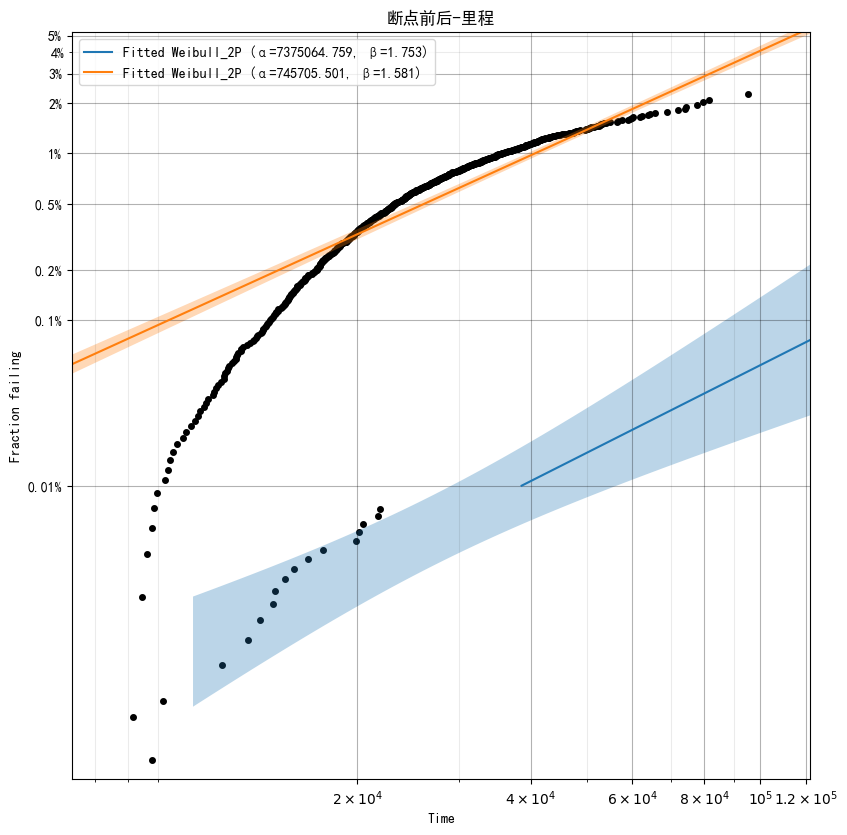

In [37]:
#assert 3>4, "Houston we've got a problem"
#故障件预处理

###数据筛选（行驶里程）

left_data = claims.loc[(claims['product_date']>'2023-06-10')&
                       (claims['total_odometer']>8000)]
right_data= vehicle.loc[(vehicle['product_date']>'2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['total_odometer'].tolist(),
    right_censored = right_data['total_odometer'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')


left_data = claims.loc[(claims['product_date']<='2023-06-10')&
                        (claims['total_odometer']>8000)]
right_data= vehicle.loc[(vehicle['product_date']<='2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['total_odometer'].tolist(),
    right_censored = right_data['total_odometer'].tolist(),
    CI_type='reliability')
plt.title('断点前后-里程')


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 24/617968 (99.99612% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          104662          102709   15292.3    716320
     Beta         1.70777        0.291714   1.22189   2.38687 

Goodness of fit    Value
 Log-likelihood -395.367
           AICc  794.735
            BIC  817.403
             AD  639.045 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1685/173795 (99.03978% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         4970.06         243.725    4514.6   5471.46
     Beta         2.24379       0.0523516   2.14349   2.34878 

Goodness of fit    Value
 Log-likelihood -19894.3
           AICc  39792.5
            BIC  39812.7
             AD  43888.1 



Text(0.5, 1.0, '断点后-使用天数')

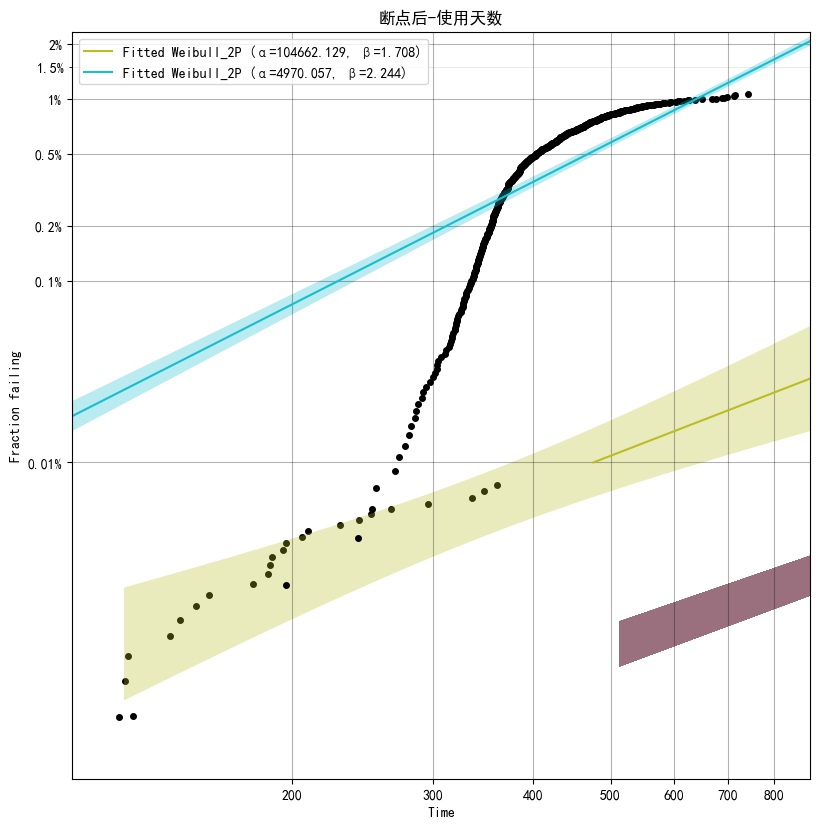

In [38]:
new_rate = 0
out = pd.DataFrame()
out['里程'] = [10000*i for i in range(1,16)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['里程'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


new_rate = 0
out = pd.DataFrame()
out['use_days'] = [100*i for i in range(1,20)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['use_days'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


left_data = claims.loc[(claims['product_date']>'2023-06-10')&(claims['use_days']>100)]
right_data= vehicle.loc[(vehicle['product_date']>'2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
#plt.title('断点后-使用天数')


left_data = claims.loc[(claims['product_date']<='2023-06-10')&(claims['use_days']>100)]
right_data= vehicle.loc[(vehicle['product_date']<='2023-06-10')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点后-使用天数')




1825

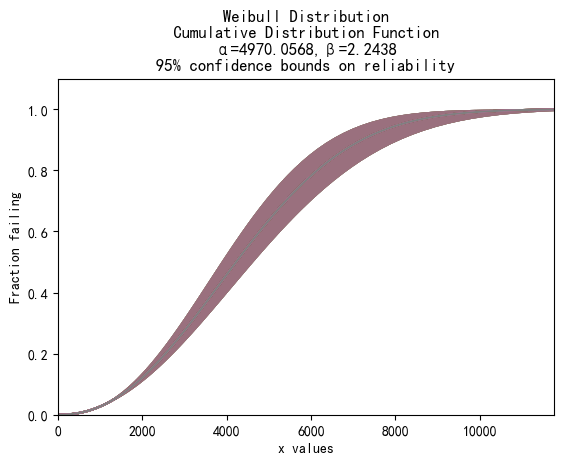

In [35]:

new_rate = 0
out = pd.DataFrame()
out['使用天数'] = [200*i for i in range(1,10)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['使用天数'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


5*365
# 供应商保修 3年6万， 理想汽车5年10万

